In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from data.cleaning import get_dataset_from_pickle
from models.utils import adfuller_test, create_weekly_heatmap
from models.autoregressive import ARIMA, SARIMAX
from models.fbprophet import FacebookProphet

/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# City of Los Angeles: Proposing a Strategy for Optimizing Parking Enforcement Deployment

**Author: Evan Gabrielson**

---

A strategy for improving the efficiency of LADOT's Parking Enforcement division should function to save the city and citizenry of Los Angeles money. From public data published by the City of LA on their [Open Budget Explorer](https://openbudget.lacity.org/#!/year/2023/operating/0/department_name/Transportation/0/program_name/Parking+Enforcement+Services/0/source_fund_name), we can see that full and part-time salaries as well as overtime account for over 99% of allocated funding. While the official number of officers is not published publicly, we can use budget data and Indeed job postings by the City of LA to create a heuristic for the number of Full-Time Officers (FTO) working for the Parking Enforcement division.

$$\text{FTO Salary} = (\$23.00 \text{ per hour}) * (40 \text{ hours per week}) * (52 \text{ weeks per year}) =  \$47,840 \text{ annually}$$
$$\text{Number of FTOs} = \$58,311,479 \text{ budgeted for salaries } / \text{ } \$47,840 \text{ per FTO salary} = 1,218 \text{ FTOs}$$

In [ ]:
fto_salary = 23 * 40 * 52
num_ftos = 58.3e6 // fto_salary
print(f"Number of FTOs: {num_ftos}")


It appears that over **1218 full-time officer units** are working for the LADOT Parking Enforcement division. 

As previously stated, to optimize the City of LA's budget, profits must be maximized per officer deployed in a given region for a given shift. We can use historical parking citation data to understand the distribution of citations (1) spatially, across the various regions of Los Angeles, and (2) temporally, across the different days of the week. The citation density distribution is significant to the City of LA's budget optimization problem because it is __directly proportional to the maximum potential revenue that can be generated by the parking enforcement department__. Once a predictor for this distribution is known, we can better estimate the demand for enforcement officers by region and time to maximize revenue per officer.

In [2]:
# Load timeseries
citations_ts = get_dataset_from_pickle('data/pickle/timeseries.pickle')
citations_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 437770 entries, 2013-12-31 07:00:00 to 2023-12-27 10:00:00
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   district        437770 non-null  category
 1   citation_count  437770 non-null  int64   
dtypes: category(1), int64(1)
memory usage: 7.1 MB


For the sake of the simplicity of this initial study, we will focus on citation data only in the district of Hollywood. We will revisit the other districts in a final modeling stage to ensure district-to-district discrepancies are correctly incorporated in the models and to allow a complete view of the City of LA's potential budget savings.

In [3]:
# Extract Hollywood-specific data
hollywood_ts = citations_ts[citations_ts['district'] == 'Hollywood']['citation_count']
hollywood_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 87555 entries, 2013-12-31 08:00:00 to 2023-12-27 10:00:00
Series name: citation_count
Non-Null Count  Dtype
--------------  -----
87555 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


#### Looking at Hollywood's Mean Weekly Citation Density

The most rudimentary approach to predicting citation density by hour and weekday is to look at an average of the citation density values across the entire timeseries for each combination of hour and weekday. It would be reasonable to assume that even this basic approach could represent a deployment scheme offering already considerable savings for the City of Los Angeles. Later on, we will examine models that take into account week-by-week differences in citation density to further enhance our savings and deployment demand prediction service.

In [ ]:
create_weekly_heatmap(hollywood_ts)

#### Check for stationarity

Before timeseries modeling can begin, we'll use the Dickey-Fuller test for stationarity and isolate districts that are not stationary on a daily basis.

**Aside:** Testing for non-stationarity with Dickey Fuller

It is important for the sake of modeling and regression techniques that our timeseries is stationary. The Dickey Fuller test allows us to determine whether our timeseries is stationary by trying to establish a value for coefficient $\rho$ in the following equation assuming our timeseries is non-stationary:

$$
x_t = \alpha + \rho x_{t-1} + \epsilon_t \quad \text{where } \alpha = \text{drift \& } \epsilon_t = \text{error term}
$$

By the definition of stationarity, we want to determine if the change in our timeseries ($\Delta x_t$) has a tendency to return to some mean. This would only occur if $\rho$ was less than 1.

$$
\Delta x_t = (\rho - 1) x_{t-1} + \epsilon_t
$$

$$
H_0 : \rho = 1 \quad \text{stationary}\\
H_1 : \rho < 1 \quad \text{non stationary}
$$

In [ ]:
# Print (Augmented) Dickey-Fuller test results
adfuller_test(hollywood_ts)

### Basic Model - ARIMA

Let's split the training and test set and get a baseline model that predicts a constant citation count for all future timesteps. We'll use an ARIMA model with 0 autoregressive (AR) terms and 0 moving average (MA) filter terms to find the future citation count.

In [4]:
# Run basic ARIMA Model
arima_model = ARIMA(hollywood_ts, split=0.8)
arima_model.fit(order=(0, 0, 0))
arima_model.results.summary()

/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         citation_count   No. Observations:                70044
Model:                          ARIMA   Log Likelihood             -451160.333
Date:                Wed, 14 Aug 2024   AIC                         902324.667
Time:                        20:31:16   BIC                         902342.980
Sample:                    12-31-2013   HQIC                        902330.315
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.2548      0.928     64.924      0.000      58.436      62.074
sigma2      2.302e+04     42.308    544.042      0.000    2.29e+04    2.31e+04
===================================================================================
Ljung-Box (L1) (Q):               31334.10   Jarque-Bera (JB):           5539188.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             5.23
Prob(H) (two-sided):                  0.62   Kurtosis:                        45.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The [Akaike Information Criterion (AIC)](https://iowabiostat.github.io/research-highlights/joe/Cavanaugh_Neath_2019.pdf) value is an estimator of model quality, which when minimized results in the optimal model in terms of simplicity and accuracy. We can compare the AIC value of our Basic ARIMA Model (in this case: 902324) with the AIC value of more advanced modeling techniques to determine whether or not our more advanced models should be preferred.

In [ ]:
arima_model.plot_diagnostics()

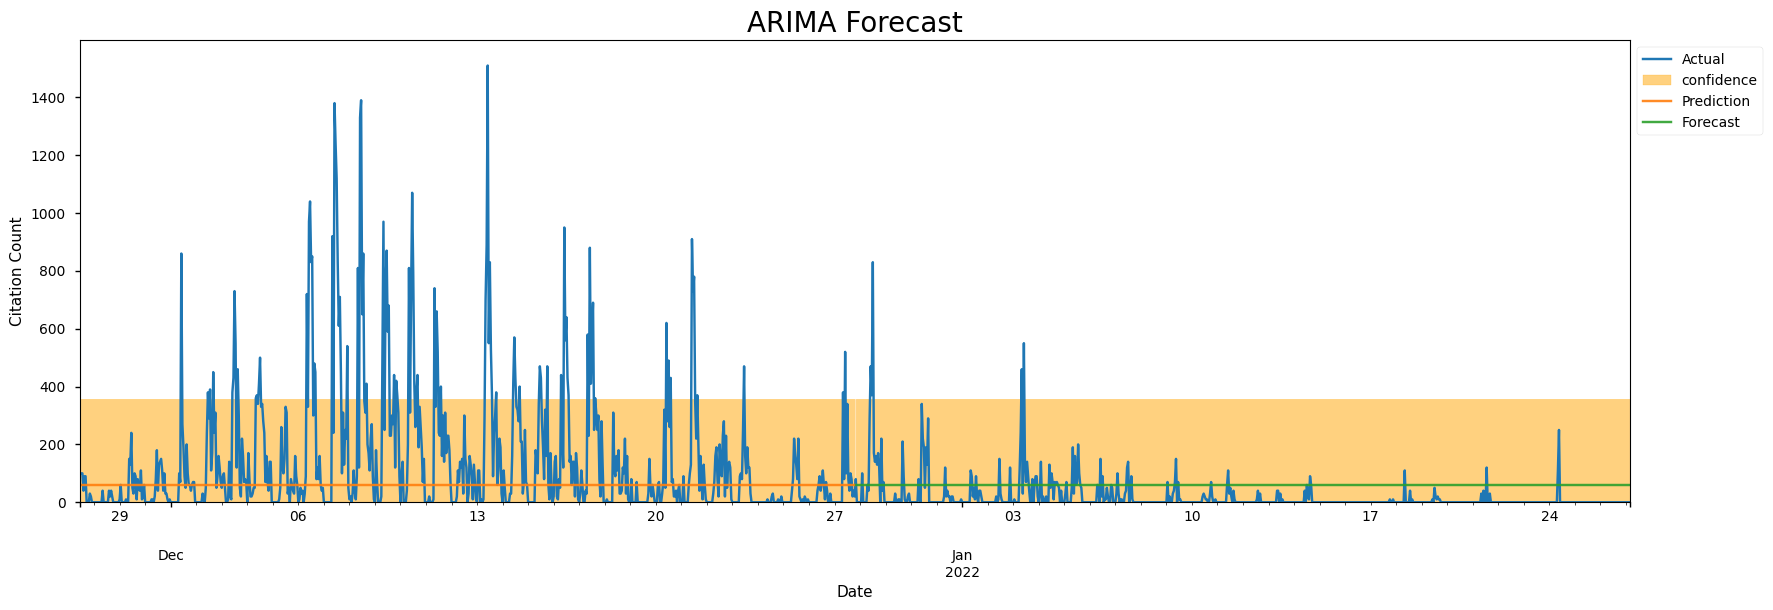

In [5]:
# Plot the trivial model
arima_model.predict()
arima_model.plot()

In [9]:
# Print RSME and ACF plots
arima_model.measure()

Training Set RMSE: 242.6833955643456
Testing Set RMSE: 73.52807048008745


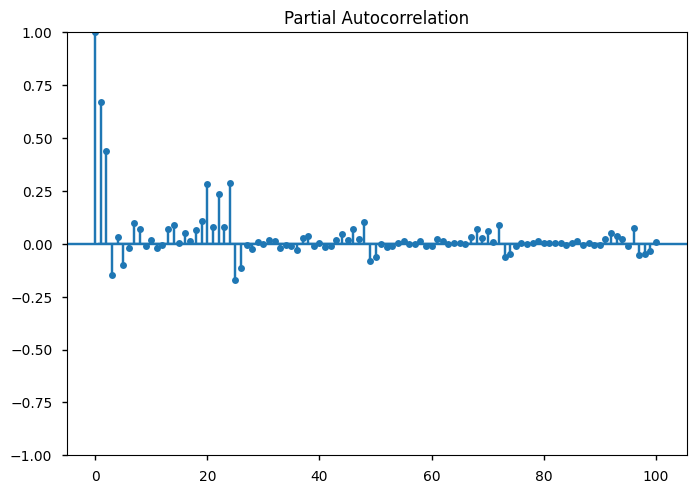

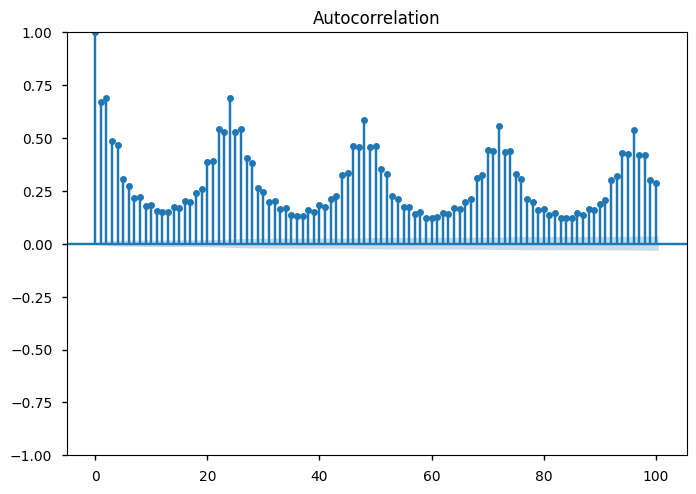

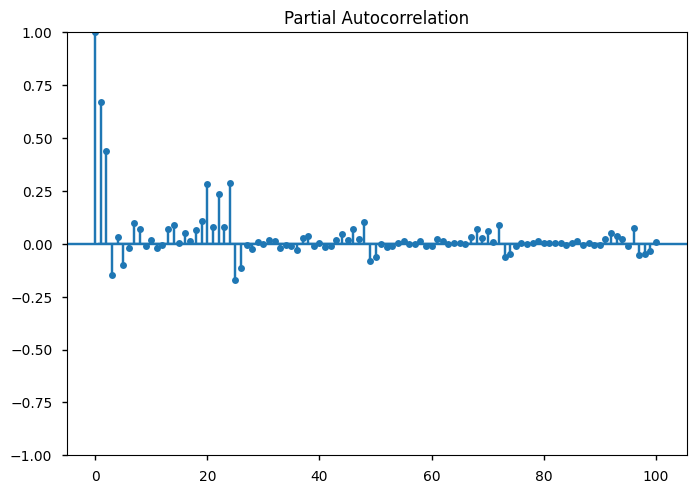

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(arima_model.train, lags=100)
plot_pacf(arima_model.train, lags=100)

#### SARIMA Model
Capturing seasonality is important, we'll use a 24 hour period to try and pick up any daily seasonality. In order to isolate the best parameters, we'll use the `auto_arima` function to search across autoregressive (AR), differencing (I) and moving average (MA) terms, as well as seasonal components.

In [19]:
# Instantiate SARIMAX model
sarimax_model = SARIMAX(hollywood_ts, split=0.8)

# Run SARIMAX Model Grid Search & print results
# sarimax_model.grid_search(max_value=2, display=True)

In [ ]:
best_order, best_seasonal_order, best_aic = sarimax_model.get_best_params()
print(f"""
      Best SARIMAX Parameters:
      ------------------------
      Order: {best_order}
      Seasonal Order: {best_seasonal_order}
      AIC Value: {best_aic}
    """)
sarimax_model.grid_search_results.to_pickle('data/pickle/sarimax_results.pickle')

In [ ]:
sarimax_results = pd.read_pickle('data/pickle/sarimax_results.pickle')
best_order, best_seasonal_order = sarimax_results.iloc[0, :3].values, sarimax_results.iloc[0, 3:-1].values
sarimax_model.fit(order=best_order, s_order=best_seasonal_order)
sarimax_model.results.summary()

In [ ]:
sarimax_model.results.plot_diagnostics(figsize=(10,10))

In [22]:
# Get SARIMA predictions
sarimax_model.predict()

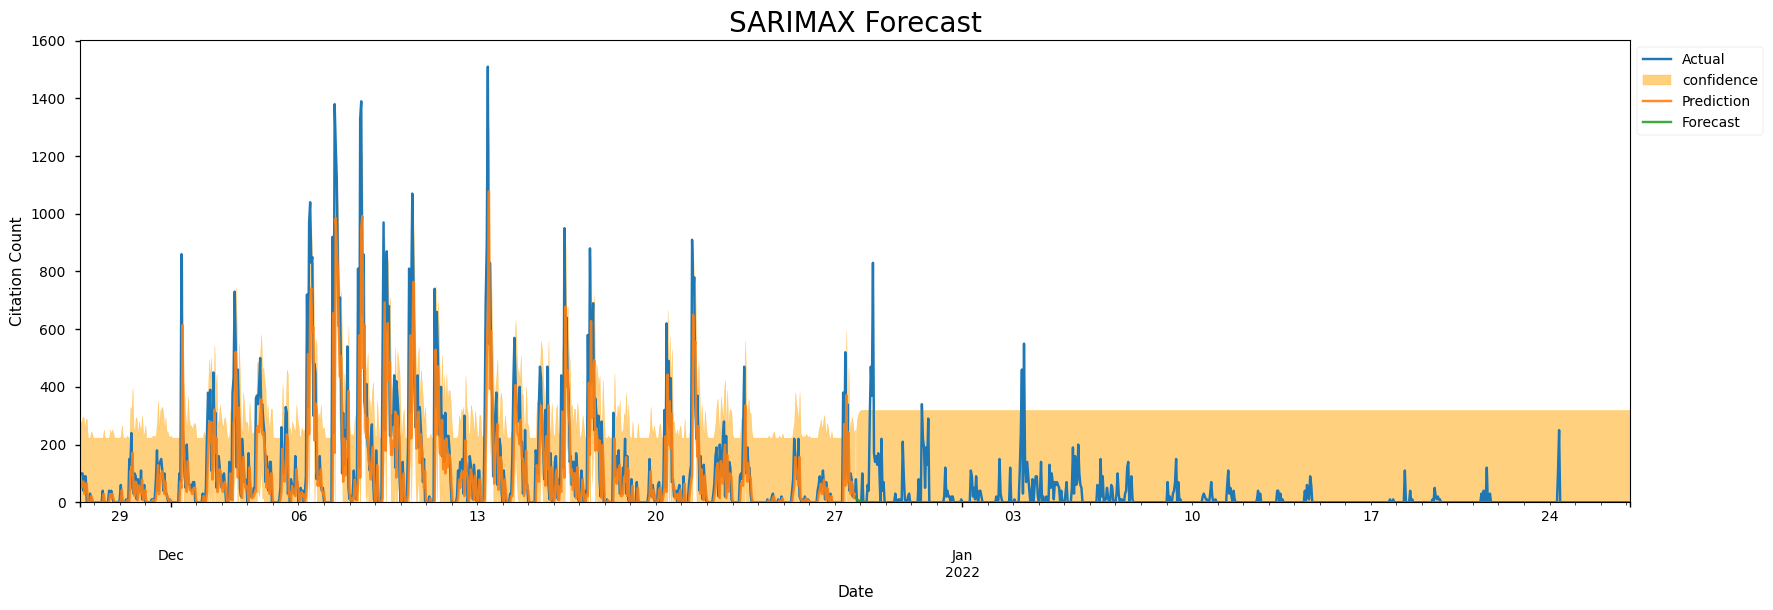

In [23]:
# Plot SARIMA predictions
sarimax_model.plot()

In [24]:
# Determine RMSE for SARIMAX
sarimax_model.measure()

Training Set RMSE: 174.15815660748692
Testing Set RMSE: 64.3107090998068


#### Facebook Prophet

In [4]:
# Instantiate the Facebook Prophet model
prophet_model = FacebookProphet(hollywood_ts, split=0.8)

# Fit the model to the training set
prophet_model.fit()

21:54:21 - cmdstanpy - INFO - Chain [1] start processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Generate forecasts
prophet_model.predict()
prophet_model.fore[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
87550,2023-12-27 06:00:00,16.526669,-169.344914,192.736730
87551,2023-12-27 07:00:00,44.921375,-145.850532,225.193257
87552,2023-12-27 08:00:00,82.899755,-96.736819,257.631298
87553,2023-12-27 09:00:00,121.573500,-62.895880,291.120122
87554,2023-12-27 10:00:00,148.776440,-38.304553,326.799580


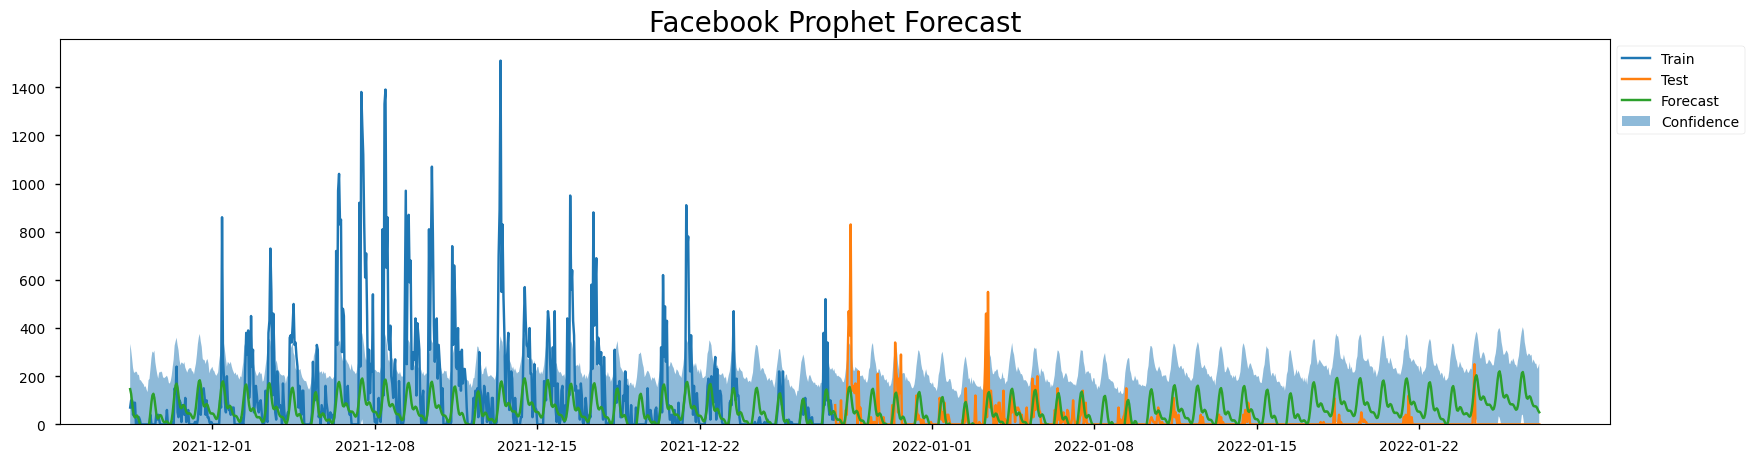

In [6]:
# Plot Facebook Prophet
prophet_model.plot()

In [9]:
# Display RMSE
prophet_model.measure()

729 729 729 729


#### CNN-LSTM

So far, we've focused on the Hollywood District to identify daily and weekly trends in hourly citation count. There is still a ton of room for improvement so let's see if a more complex model like a Convolutional Neural Network with Long Short-Term Memory better captures complex seasonality.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

In [ ]:
# Hyperparameters
n_seq = 4          # Sub-sequences
n_steps = 12       # Steps per sub-sequence
n_filters = 64     # Output filters from convolution
n_kernel = 3       # Convolutional window size
n_nodes = 100      # Nodes in LSTM & dense layers
n_epochs = 50      # Number of epochs to run
n_batch = 100      # Batch size
n_input = n_seq * n_steps

train_data = train_ts.reset_index().rename(columns={'issue_datetime': 'x', 'citation_count': 'y'})
X_train, Y_train = train_data['x'], train_data['y']

val_data = test_ts.reset_index().rename(columns={'issue_datetime': 'x', 'citation_count': 'y'})
X_val, Y_val = val_data['x'], val_data['y']

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader for training and validation data
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

In [ ]:


# Assuming train_x, train_y, val_x, val_y are prepared as in the original code
# For demonstration, I'll assume they are already in the required shape and normalized
# train_x.shape = (num_samples, n_seq, n_steps, 1)
# train_y.shape = (num_samples,)
# val_x.shape = (num_samples, n_seq, n_steps, 1)
# val_y.shape = (num_samples,)

train_loader = DataLoader(train_dataset, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=n_batch, shuffle=False)

# Define the CNN-LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_filters, kernel_size=n_kernel)
        self.conv2 = nn.Conv1d(in_channels=n_filters, out_channels=n_filters, kernel_size=n_kernel)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(n_filters * ((n_steps - 2 * (n_kernel - 1)) // 2), n_nodes, batch_first=True)
        self.fc1 = nn.Linear(n_nodes, n_nodes)
        self.fc2 = nn.Linear(n_nodes, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size, seq_len, step_len, _ = x.size()
        x = x.view(-1, step_len, 1).transpose(1, 2)  # Reshape to (batch_size*seq_len, step_len, 1) -> (batch_size*seq_len, 1, step_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = x.view(batch_size, seq_len, -1)  # Reshape back to (batch_size, seq_len, flattened feature size)
        x, _ = self.lstm(x)
        x = self.fc1(x[:, -1, :])  # Only take the last output from LSTM
        x = self.relu(x)
        x = self.fc2(x)
        return x